In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pathlib
from statsmodels.stats.multitest import multipletests
import sys
from os.path import join
path_to_file = str(pathlib.Path().resolve())

import pickle
retro_path = join(path_to_file, "..", "Results", "Retrospective")
alphas = [0.05, 0.1, 0.2]

dir_path = join(path_to_file, "../../")

In [2]:
import matplotlib.colors as mcolors

method = "kernelshap" # "ss"
Method = "KernelSHAP" # "Shapley Sampling"
dataset = "credit"
with open(join(retro_path, method+"_"+dataset), 'rb') as f:
    retro_results = pickle.load(f)
shap_vals = retro_results["shap_vals"]
N_verified_all = retro_results["N_verified"]
N_verified = N_verified_all.reshape(-1, 3)

## Compare with number of rejections from using Holm's method

This is benchmarking against Neuhof and Benjamini, 2024.

In [3]:
output_path = join(retro_path, f"holm_{method}_{dataset}.npy")
N_verified_holm_all = np.load(output_path)

N_verified      = N_verified_all.reshape(-1, len(alphas))
N_verified_holm = np.array(N_verified_holm_all).reshape(-1, len(alphas))


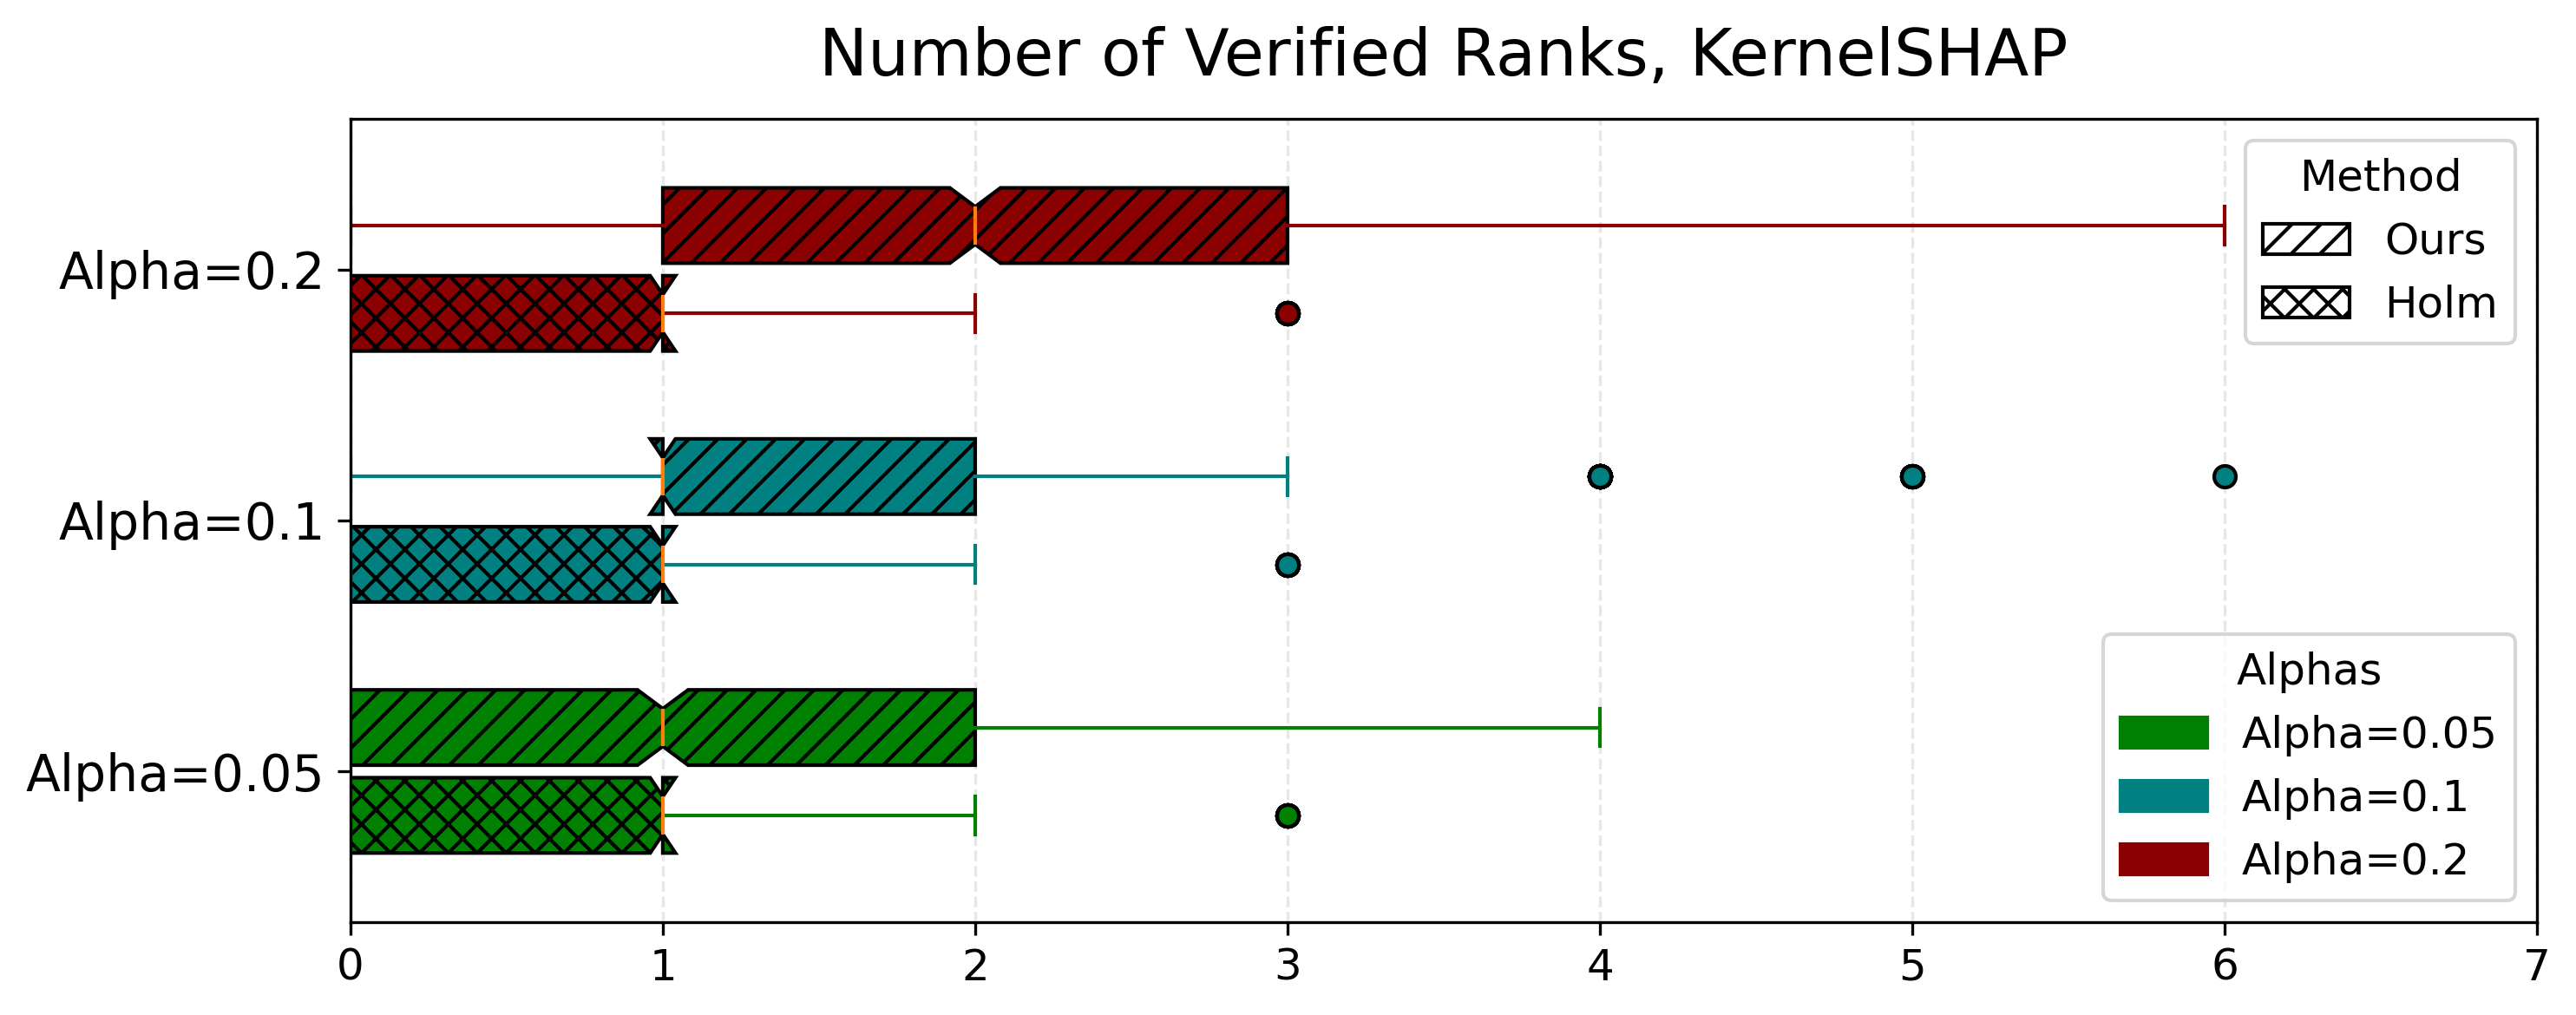

In [17]:

colors  = ["green", "teal", "darkred"]
hatches = ['///', 'xxx']  # ours vs. Holm patterns

box_width = 0.3
offset    = box_width+.05
centers   = np.arange(len(alphas))

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

for i, alpha in enumerate(alphas):
    y = centers[i]
    # Ours
    ax.boxplot(
        N_verified[:, i],
        positions=[y + offset/2],
        widths=box_width,
        notch=True,
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], edgecolor='black', hatch=hatches[0]),
        capprops=dict(color=colors[i]),
        whiskerprops=dict(color=colors[i]),
        flierprops=dict(marker='o', markerfacecolor=colors[i], markeredgecolor='black')
    )
    # Holm
    ax.boxplot(
        N_verified_holm[:, i],
        positions=[y - offset/2],
        widths=box_width,
        notch=True,
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], edgecolor='black', hatch=hatches[1]),
        capprops=dict(color=colors[i]),
        whiskerprops=dict(color=colors[i]),
        flierprops=dict(marker='o', markerfacecolor=colors[i], markeredgecolor='black')
    )

ax.set_yticks(centers)
ax.set_yticklabels([f"Alpha={a}" for a in alphas], fontsize=14)
ax.set_ylim(centers[0] - .6, centers[-1] + .6) # 1
# ax.set_xlabel("Number of Verified Ranks", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.set_xlim(0, max(N_verified.max(), N_verified_holm.max()) + 1)
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_title("Number of Verified Ranks, KernelSHAP", fontsize=18, pad=12)

# Legends
method_patches = [
    mpatches.Patch(facecolor='white', hatch=hatches[0], edgecolor='black', label='Ours'),
    mpatches.Patch(facecolor='white', hatch=hatches[1], edgecolor='black', label='Holm'),
]
alpha_patches = [mpatches.Patch(color=colors[i], label=f"Alpha={alphas[i]}") for i in range(len(alphas))]

method_legend = ax.legend(
    handles=method_patches,
    title="Method",
    loc='upper right',
    frameon=True,
    fontsize=12,
    title_fontsize=12
)
ax.add_artist(method_legend)

ax.legend(
    handles=alpha_patches,
    title="Alphas",
    loc='lower right',
    frameon=True,
    fontsize=12,
    title_fontsize=12
)

plt.tight_layout()
plt.savefig(join(dir_path, "Experiments", "Figures", "num_stable_ranks_"+method+".pdf"), 
            bbox_inches="tight", format="pdf")
plt.show()

### Visualize just our method

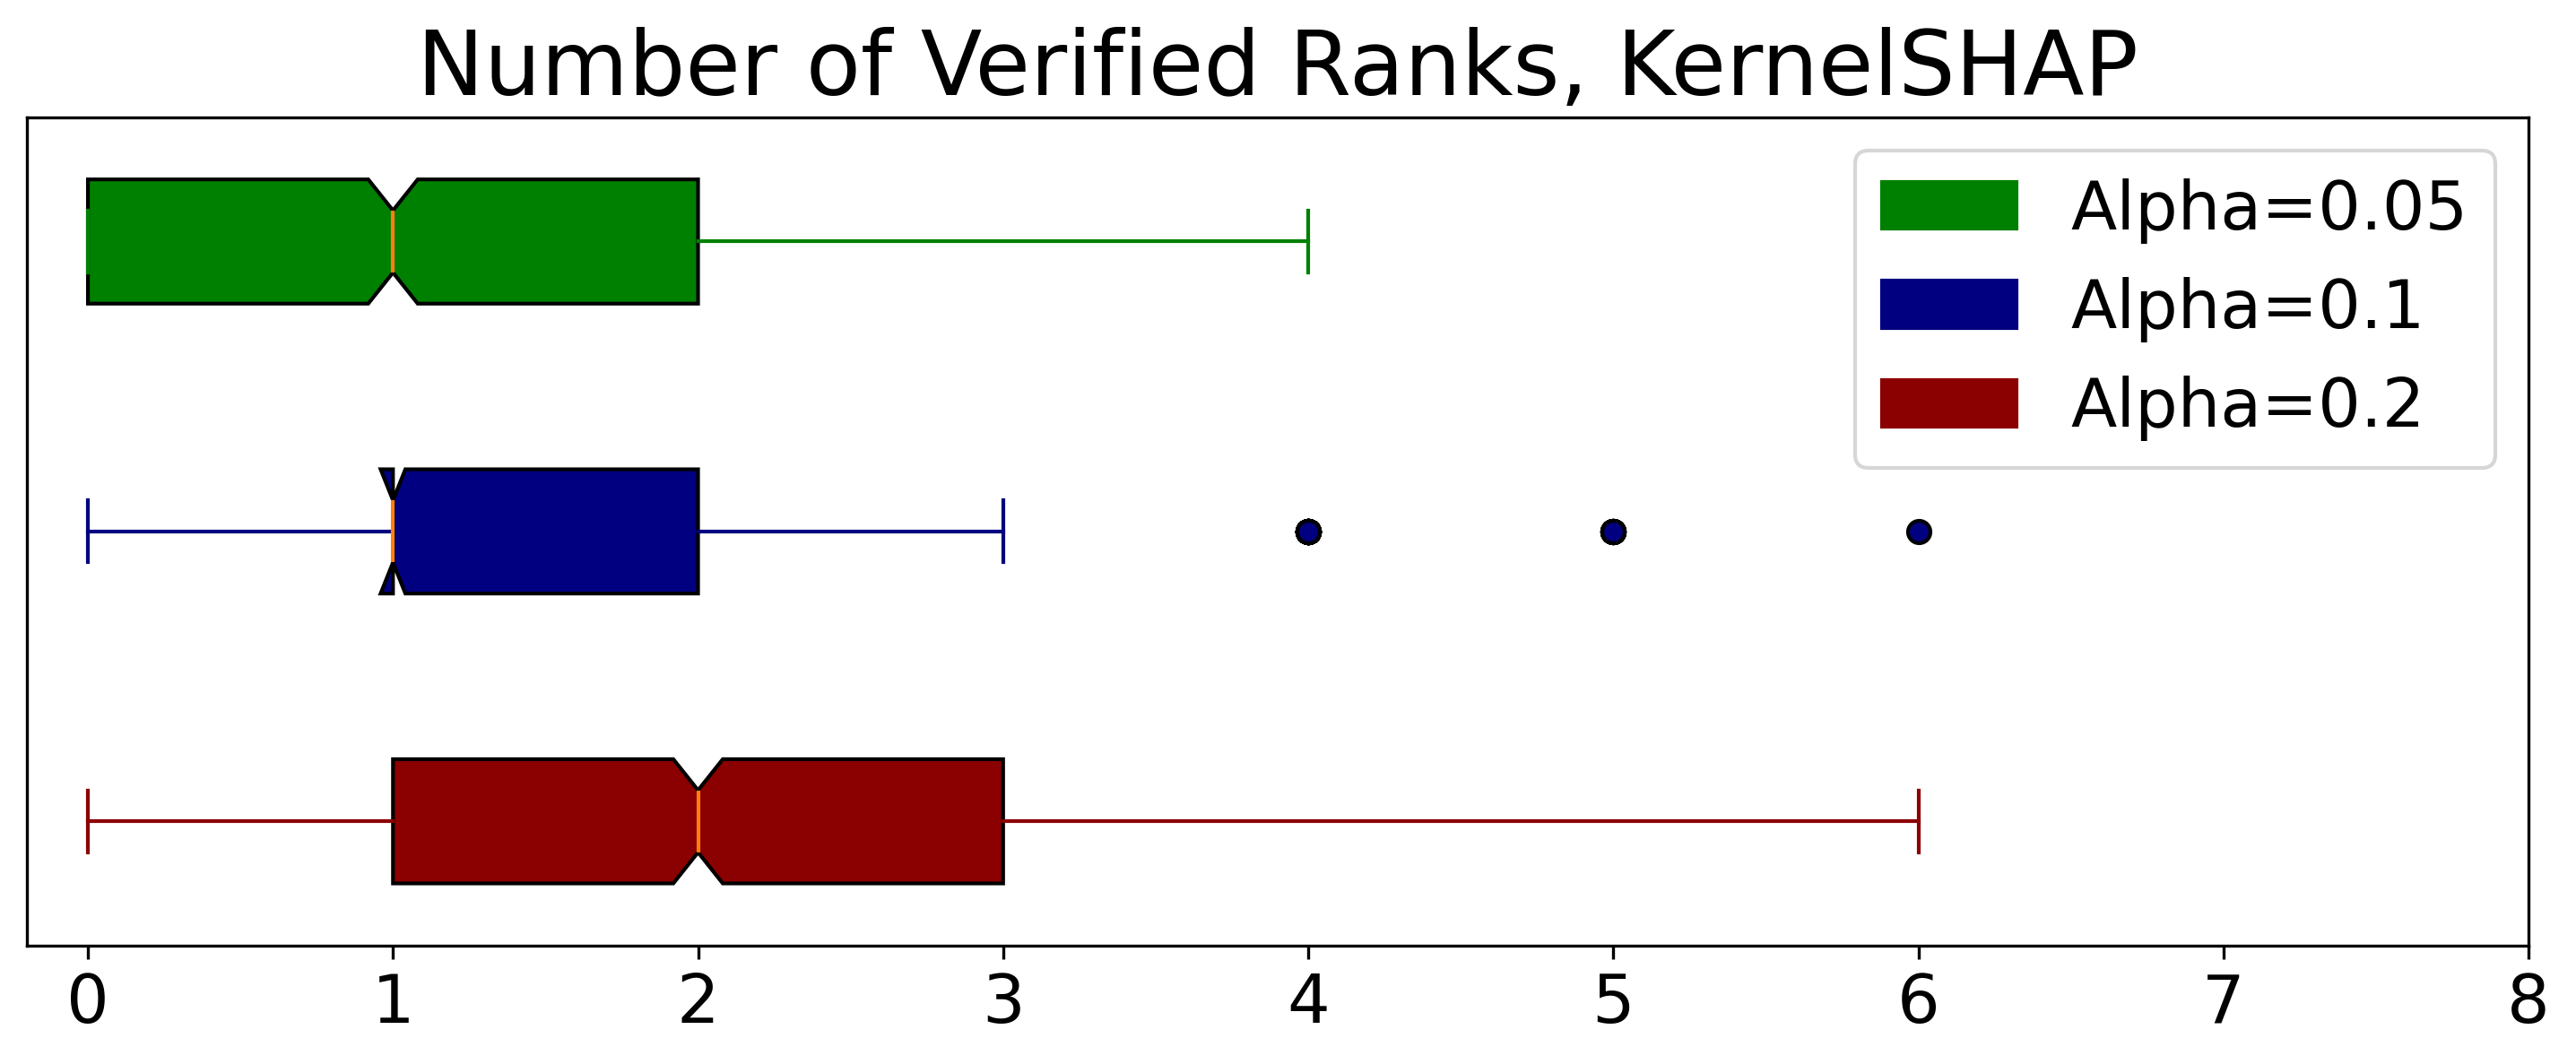

In [ ]:
offset = 0.25#0.5
plt.figure(figsize=(12,4), dpi=300)
colors = ["green", "navy", "darkred"]
offsets = np.array([offset, 0, -offset])
for i in range(3):
    c = colors[i]
    off = offsets[i]
    plt.boxplot(N_verified[:, i].T, positions=[off], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color='black'),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(markerfacecolor=c, markeredgecolor='black', marker='o'),
            vert=False
            )
    plt.xlim(right=np.max(N_verified)+2)
    plt.ylim(-.5, .5)

cols = ["Alpha="+str(alpha) for alpha in alphas]
patches = []
for i in range(3):
    patches.append(mpatches.Patch(color=colors[i], label=cols[i]))
plt.legend(handles=patches, fontsize=18, loc='upper right')
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.xticks(fontsize=18)
plt.title(f"Number of Verified Ranks, {Method}", fontsize=24)
# plt.savefig(join(dir_path, "Experiments", "Figures", "num_stable_ranks_"+method+".pdf"), 
#             bbox_inches="tight", format="pdf")
plt.show()
